In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

C:\Users\Conor\Anaconda3\python.exe
3.6.8 |Anaconda custom (64-bit)| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


In [2]:
%load_ext autoreload

%autoreload 2

In [735]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

# Home-PC

In [390]:
import os.path

file_place = r"C:\Users\Conor\DataSets"

Breast_DF = pd.read_pickle(os.path.join(file_place,"Breast_mie_corrected"))

In [387]:
import os.path

file_place = r"C:\Users\Conor\DataSets"

Breast_DF = pd.read_pickle(os.path.join(file_place,"Breast_data_raw"))

Remove blood and Necrosis from the dataset

In [512]:
indices = (Breast_DF.reset_index().Label != "Blood") & (Breast_DF.reset_index().Label != "Necrosis") & (Breast_DF.reset_index().Label != "Non_malignant Epithelium") & (Breast_DF.reset_index().Label != "Malignant Epithelium")

Breast_DF = Breast_DF[indices.values]#.head()

# Preprocessing

Preprocessing method, maybe make this all one pipe?

In [514]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler

steps = [
         #("Normalise", Normalizer(norm = "l1"))
         ("RobustScaler", RobustScaler())
        ]

pipe  = Pipeline(steps)

In [515]:
import Tissue_Analysis_Tools as TAT

PCA_NR_Components = 20

dataframe = TAT.process_data(Breast_DF, paraffin = (1340,1490))#, balance = "Type")

PCA_reduced = TAT.PCA_denoise(dataframe, PCA_NR_Components)

values = pipe.fit_transform(PCA_reduced.T).T

Breast_DF_P = pd.DataFrame(values, index = dataframe.index, columns = dataframe.columns)

Processing


C:\Users\Conor\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Analysis

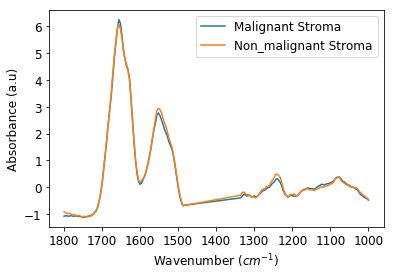

In [516]:
plt.clf()

for name, df in Breast_DF_P.groupby(level = y_label):
    
    plt.plot(df.mean(axis = 0), label = name)

plt.ylabel("Absorbance (a.u)")
plt.xlabel("Wavenumber $(cm^{-1})$")
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [ ]:
index = DATA.reset_index().Label == DATA.reset_index().Label.value_counts().idxmin()

print(len(DATA[index.values].reset_index()["Core"].value_counts()))

# Dataset partitioning

In [957]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

lb = LabelBinarizer()

DATA = Breast_DF_P#.sample(5000)

DATA = DATA.sample(frac = 1) # Shuffle the dataframe randomly

y_label = "Label"

X = DATA
Y = DATA.reset_index()[y_label]
lb.fit(Y)

Y_b = pd.DataFrame(lb.transform(Y), index = Y.index)

# split set by patients
train_p, valid_p = train_test_split(np.unique(Breast_DF_P.reset_index()["Core"])
                                    , test_size = 0.1, random_state = 42, shuffle = True)

# Keep a separate validation set aside 
#X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)

# Training and validation sets on patient basis
X_train = X[X.reset_index()["Core"].isin(train_p).values]
X_valid = X[X.reset_index()["Core"].isin(valid_p).values]

y_train = X_train.reset_index()[y_label]
y_valid = X_valid.reset_index()[y_label]

pd.DataFrame(X_valid.values, index = y_valid.values).round(6).to_csv(r"E:\Validation.csv".format(i+1), header = None)

print("Train set: \n", y_train.value_counts(), "\n")
print("Validation set: \n", y_valid.value_counts(), "\n")

# Create dataframes containing the binary labels for each class
y_train = pd.DataFrame(lb.transform(y_train), index = y_train.index)
y_valid = pd.DataFrame(lb.transform(y_valid), index = y_valid.index)

if len(np.unique(Y)) == 2: y_train[1] = y_train[0].map({0:1, 1:0})
if len(np.unique(Y)) == 2: y_valid[1] = y_valid[0].map({0:1, 1:0})

Train set: 
 Malignant Stroma        65500
Non_malignant Stroma    35397
Name: Label, dtype: int64 

Validation set: 
 Malignant Stroma        6396
Non_malignant Stroma    4018
Name: Label, dtype: int64 



In [958]:
from sklearn.metrics import confusion_matrix

def sens_spec_etc(y_true, y_predicted):
    
    labels = np.unique(y_true)
    
    conf_mat = confusion_matrix(y_true, y_predicted)
    
    classes = dict()
    
    for i, name in enumerate(labels):
        stats = dict()
        
        stats['TP'] = conf_mat[i,i]
        stats['FP'] = np.sum(conf_mat[:,i]) - stats['TP']
        stats['FN'] = np.sum(conf_mat[i,:]) - stats['TP']
        stats['TN'] = np.sum(conf_mat) - stats['TP'] - stats['FP'] - stats['FN']
        
        stats['Sens'] = stats["TP"]/(stats["TP"] + stats["FN"])
        stats["Spec"] = stats["TN"]/(stats["TN"] + stats["FP"])
        stats["Youden's"] = stats['Sens'] + stats["Spec"] -1
        
        classes[name] = stats
        
    return classes

In [959]:
index = DATA.reset_index().Label == DATA.reset_index().Label.value_counts().idxmin()

print(len(DATA[index.values].reset_index()["Core"].value_counts()))

13


# HyperOpt Training - XGBoost

In [11]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

This will ouput a score for the current hyperparameter configuration 

In [1066]:
import xgboost as xgb

def hyper_opt_search_XGBoost(X, y, grouping, weight_binary = False
                             , optimiser = tpe.suggest, random_state = 42
                             , cores = 1, n_evals = 3, k_splits = 2):
    
    from sklearn.model_selection import train_test_split, GroupKFold
    from sklearn.metrics import roc_auc_score
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    def score(params):
        
        loss_cv = []
        scores = []
        
        i = 0
        
        for train_index, test_index in GroupKFold(k_splits).split(X, y, grouping):
            
            # Uncomment to save folds
            #X_Data = np.vstack([X[train_index], X[test_index]])
            #Y_Data = lb.inverse_transform(np.hstack([y[train_index], y[test_index]]))
            #pd.DataFrame(X_Data, index=Y_Data).round(6).to_csv(r"F:\fold_{}.csv".format(i+1), header = None)

            dtrain = xgb.DMatrix(X[train_index], label=y[train_index])
            dtest = xgb.DMatrix(X[test_index], label=y[test_index])

            watchlist = [(dtest, 'eval'), (dtrain, 'train')]

            xgb_cl = xgb.train(params, dtrain, evals=watchlist, verbose_eval=False)

            predictions = xgb_cl.predict(dtest, ntree_limit = xgb_cl.best_iteration + 1)

            # TODO: try and get the y_labels from dtest
            score = roc_auc_score(y[test_index], predictions)
            scores.append(score)
            
            loss = 1 - score
            
            loss_cv.append(loss)
            
        print("\tScore {0}\n\n".format(1-loss))
        return {'loss': loss.mean(), 'status': STATUS_OK, 'scores': scores}
    
    space = {
        "early_stopping_round" : 10,
        "n_classes" : 2,
        "scale_pos_weight" : 1/(np.sum(y)/y.shape[0]),
        'n_estimators': hp.quniform('n_estimators', 10, 1000, 1),
        'learning_rate': hp.quniform('learning_rate', 0.025, 0.7, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(3, 15, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 8, 1),
        'subsample': hp.quniform('subsample', 0.3, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.3, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 0.95, 0.05),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': cores,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state      
    }

    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=n_evals)
    
    best["scale_pos_weight"] = space["scale_pos_weight"]
    best["n_estimators"] = int(best["n_estimators"])

    return best

from sklearn.model_selection import KFold

grouping = X_train.reset_index()["Core"]

indices = []

i = 0

for train_index, test_index in KFold(5).split(grouping):
    
    indices.append(train_index)

    # Uncomment to save folds
    X_Data = np.vstack(X_train.values[test_index])
    Y_Data = lb.inverse_transform(np.hstack(y_train[0][test_index]))
    output = pd.DataFrame(X_Data, index=Y_Data)
    output.round(6).to_csv(r"F:\fold_{}.csv".format(i+1), header = None)
    
    print(output.index.value_counts())

    i = i+1

In [960]:
%time
from sklearn.model_selection import train_test_split, GroupKFold, LeaveOneGroupOut

xgbinary_classifiers = dict()

for i, name in enumerate(np.unique(Y)):
    
    print("\n{}: {}".format(i + 1, name))
    
    best_hyperparams = hyper_opt_search_XGBoost(X_train.values,
                                        y_train[i].values,
                                        X_train.reset_index()["Core"],
                                        weight_binary = True,
                                        optimiser = tpe.suggest,
                                        random_state = 42,
                                        cores = -1,
                                        n_evals = 20,
                                        k_splits = 5)
                                #, trials = Trials())
    
    ## TODO: append best classifier to dictionary, store any other
    ## relevant variables with it using trials.
    clf_xgb = xgb.XGBClassifier()
    
    # Set the parameters which are best for that particular class
    clf_xgb.set_params(**best_hyperparams)
    clf_xgb.fit(X_train.values, y_train[i])

    xgbinary_classifiers[name] = clf_xgb
    
    #if len(np.unique(Y)) == 2: break

Wall time: 0 ns

1: Malignant Stroma
	Score 0.8805928253788691


	Score 0.8729755612334459


	Score 0.8625578397144584


	Score 0.8888645969456417


	Score 0.8814744153615104


	Score 0.8783000477852977


	Score 0.8568480915137212


	Score 0.8802285209962748


	Score 0.8839777798365549


	Score 0.8573639338027345


	Score 0.8880617161748356


	Score 0.877473942384584


	Score 0.8831233202005033


	Score 0.8600242193442686


	Score 0.8931044791402548


	Score 0.878876489633516


	Score 0.8910800403737005


	Score 0.8547229769265277


	Score 0.8768948723449903


	Score 0.8561378362037019


100%|██████████████████████████████████████████████████| 20/20 [30:15<00:00, 83.81s/it, best loss: 0.10689552085974519]

2: Non_malignant Stroma
	Score 0.8734337978584384


	Score 0.8541065222055353


	Score 0.8732697626338477


	Score 0.8792083926586179


	Score 0.8140149402196173


	Score 0.856181013633438


	Score 0.8855450547092899


	Score 0.8575989643268125


	Score 0.876145111271479


	Score 0.8

In [118]:
from sklearn.metrics import confusion_matrix, roc_auc_score

In [961]:
def bin_predict(x_array, classifiers):
    
    content = {name: classifier.predict_proba(x_array)[:,1] for name, classifier in classifiers.items()}
    output = pd.DataFrame(content)
    
    # Normalise probability
    output = output.div(output.sum(axis = 1), axis = 0)

    return output

probs = bin_predict(X_valid.values, binary_classifiers)

# Results

In [1084]:
probs = bin_predict(X_valid.values, xgbinary_classifiers)

aucs = pd.Series({class_name: roc_auc_score(y_valid.iloc[:,i], o_probs.iloc[:,i]) for i, class_name in enumerate(o_probs.columns)}, name = "AUC")

results = pd.DataFrame(sens_spec_etc(lb.inverse_transform(y_valid.values), probs.idxmax(axis = 1))).append(aucs)#, ignore_index = True)

In [1085]:
results

,Malignant Stroma,Non_malignant Stroma
FN,166.000000,629.000000
FP,629.000000,166.000000
Sens,0.958686,0.901657
Spec,0.901657,0.958686
TN,5767.000000,3852.000000
TP,3852.000000,5767.000000
Youden's,0.860343,0.860343
AUC,0.983548,0.983548


In [1068]:
import matplotlib as mpl

print(mpl.get_configdir())
plt.style.reload_library()
plt.style.use('ScanCan_Style')

C:\Users\Conor\.matplotlib


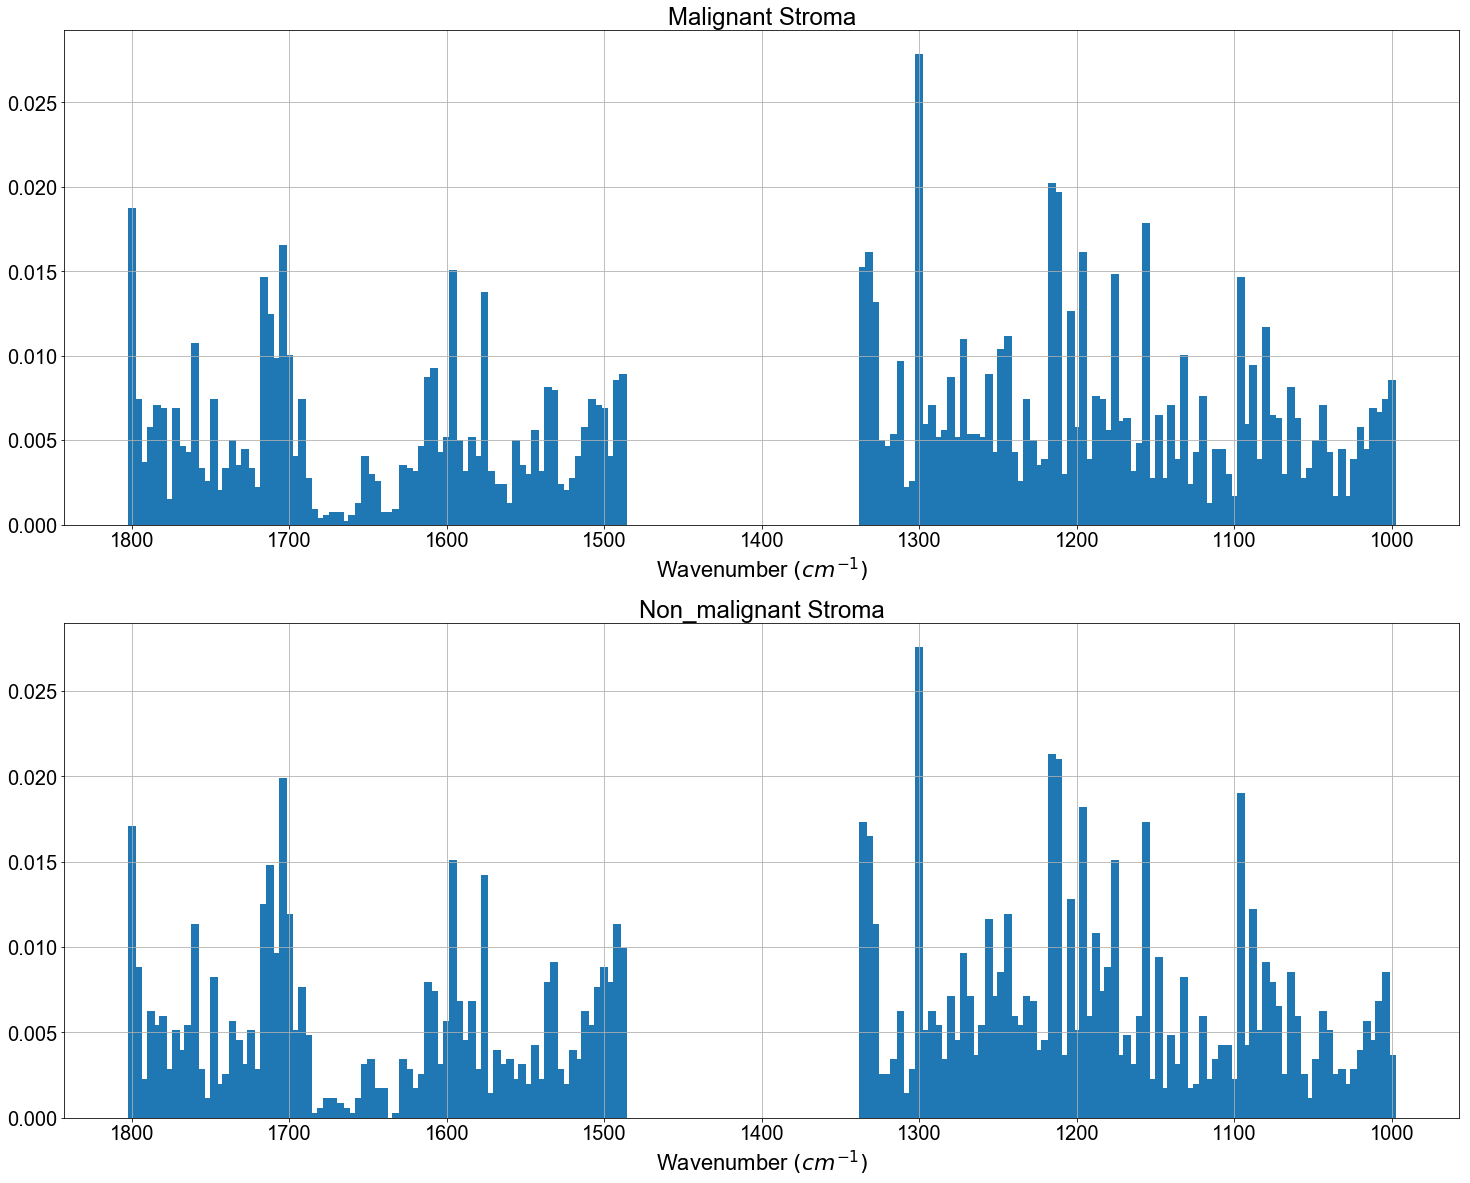

In [1069]:
fig, axes = plt.subplots(nrows = len(xgbinary_classifiers), ncols = 1, figsize = (25,len(binary_classifiers)*10))

#fig.suptitle("Relative wavenumber importances", fontsize = 16)

for title, plot, ax in zip(xgbinary_classifiers.keys(), xgbinary_classifiers.values(), axes.flatten()):
    
    ax.grid()
    ax.bar(X.columns, plot.feature_importances_, width = 5)
    #ax.set_xlim(min(X.columns), max(X.columns))
    ax.set_title(title)
    ax.invert_xaxis()
    ax.set_xlabel("Wavenumber $(cm^{-1})$")
    
plt.show()
fig.savefig(r"C:\Users\Conor\Google Drive\PhD\Breast_Cancer_Analysis_April\Feature_Importances_XGBoost.svg"
           ,format = "svg"
           ,bbox_inches = "tight")

# Hyperopt on other classifiers

In [927]:
def hyper_opt_search(clf, space, X, y, grouping, optimiser = tpe.suggest, random_state = 42, cores = 2, n_evals = 3):

    from sklearn.model_selection import train_test_split, GroupKFold
    from sklearn.metrics import roc_auc_score, confusion_matrix
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    def score(params):
        
        loss_cv = []
        
        for train_index, test_index in GroupKFold(3).split(X, y, grouping):

            X_train, Y_train = X[train_index], y[train_index]
            X_test, Y_test = X[test_index], y[test_index]
            
            clf.fit(X_train, Y_train)

            predictions = clf.predict_proba(X_test)
            
            score = roc_auc_score(y[test_index], predictions[:,1])

            loss = 1 - score
            
            loss_cv.append(loss)
            
        #print("\tScore {0}\n\n".format(1-loss))
        return {'loss': loss.mean(), 'status': STATUS_OK}
    
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=n_evals)
    return best

In [966]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = {
    "SVM": (SVC(probability = True, kernel = "linear", class_weight = "balanced", gamma = "auto"), 
            {'C': hp.loguniform("C", np.log(1e-5), np.log(1e5))
            })
    
    ,"KNN": (KNeighborsClassifier(),
            {'n_neighbors': hp.choice('n_neighbors', np.arange(2, 30, dtype=int))
            ,'leaf_size': hp.choice('leaf_size', np.arange(10,60, dtype = int))
            ,'n_jobs': -1})
    
    ,"RF": (RandomForestClassifier(),
            {'n_estimators ': hp.choice('n_estimators', np.arange(10,1000,5))
            ,'max_depth': hp.choice('max_depth', np.arange(1,30,1))
            ,'min_samples_split': hp.quniform('min_samples_split', 0.3, 1, 0.05)})
    
    ,"LDA": (LinearDiscriminantAnalysis(solver = "lsqr"),
            {'eigen': hp.choice('shrinkage', [None, "auto"])})
    
    ,"LR": (LogisticRegression(class_weight = "balanced", n_jobs = -1),
            {'C': hp.loguniform("C", np.log(1e-5), np.log(1e5))})
}

In [967]:
%time
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.base import clone

# Dictionary to store the best classifier after optimisation
classifier_results = dict()

for clf_name, clf_u, params in zip(classifiers.keys(), list(zip(*classifiers.values()))[0], list(zip(*classifiers.values()))[1]):

    # Dictionary to store the binary classifier for each class
    binary_classifiers = dict()
    
    if clf_name in ["KNN", "SVM", "RF"] : continue

    for i, name in enumerate(np.unique(Y)):
        
        clf = clone(clf_u)
        print("\n{}".format(name))

        best_hyperparams = hyper_opt_search(clf,
                                            params,
                                            X_train.values,
                                            y_train[i].values,
                                            X_train.reset_index()["Core"],
                                            optimiser = tpe.suggest,
                                            random_state = 42,
                                            cores = -1,
                                            n_evals = 20)

        ## TODO: append best classifier to dictionary, store any other
        ## relevant variables with it. Use trials.

        # Set the parameters which are best for that particular class
        clf = clf.set_params(**best_hyperparams)
        
        clf.fit(X_train.values, y_train[i])
        
        binary_classifiers[name] = clf
        
    classifier_results[clf_name] = binary_classifiers

Wall time: 0 ns

Malignant Stroma
100%|██████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.62s/it, best loss: 0.05606721577590146]

Non_malignant Stroma
100%|██████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.68s/it, best loss: 0.05606721577590146]

Malignant Stroma
  0%|                                                                             | 0/20 [00:00<?, ?it/s, best loss: ?]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

  5%|██▌                                                | 1/20 [00:11<03:43, 11.76s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 10%|█████                                              | 2/20 [00:23<03:30, 11.69s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 15%|███████▋                                           | 3/20 [00:34<03:17, 11.63s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 20%|██████████▏                                        | 4/20 [00:46<03:04, 11.56s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 25%|████████████▊                                      | 5/20 [00:57<02:52, 11.51s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 30%|███████████████▎                                   | 6/20 [01:08<02:40, 11.49s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 35%|█████████████████▊                                 | 7/20 [01:20<02:30, 11.61s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 40%|████████████████████▍                              | 8/20 [01:32<02:19, 11.61s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 45%|██████████████████████▉                            | 9/20 [01:43<02:07, 11.55s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 50%|█████████████████████████                         | 10/20 [01:55<01:54, 11.49s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 55%|███████████████████████████▌                      | 11/20 [02:06<01:43, 11.46s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 60%|██████████████████████████████                    | 12/20 [02:18<01:31, 11.46s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 65%|████████████████████████████████▌                 | 13/20 [02:29<01:20, 11.52s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 70%|███████████████████████████████████               | 14/20 [02:41<01:09, 11.62s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 75%|█████████████████████████████████████▌            | 15/20 [02:53<00:58, 11.80s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 80%|████████████████████████████████████████          | 16/20 [03:05<00:46, 11.71s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 85%|██████████████████████████████████████████▌       | 17/20 [03:16<00:34, 11.66s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 90%|█████████████████████████████████████████████     | 18/20 [03:28<00:23, 11.75s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 95%|███████████████████████████████████████████████▌  | 19/20 [03:40<00:11, 11.62s/it, best loss: 0.05733148980015168]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

100%|██████████████████████████████████████████████████| 20/20 [03:51<00:00, 11.56s/it, best loss: 0.05733148980015168]


C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Non_malignant Stroma
  0%|                                                                             | 0/20 [00:00<?, ?it/s, best loss: ?]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

  5%|██▌                                                | 1/20 [00:11<03:35, 11.36s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 10%|█████                                              | 2/20 [00:22<03:24, 11.35s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 15%|███████▋                                           | 3/20 [00:34<03:12, 11.35s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 20%|██████████▏                                        | 4/20 [00:45<03:01, 11.36s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 25%|████████████▊                                      | 5/20 [00:56<02:50, 11.34s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 30%|███████████████▎                                   | 6/20 [01:07<02:38, 11.32s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 35%|█████████████████▊                                 | 7/20 [01:19<02:28, 11.42s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 40%|████████████████████▍                              | 8/20 [01:30<02:16, 11.40s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 45%|██████████████████████▉                            | 9/20 [01:42<02:05, 11.40s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 50%|█████████████████████████                         | 10/20 [01:53<01:53, 11.38s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 55%|███████████████████████████▌                      | 11/20 [02:05<01:43, 11.56s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 60%|██████████████████████████████                    | 12/20 [02:17<01:32, 11.52s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 65%|████████████████████████████████▌                 | 13/20 [02:29<01:21, 11.67s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 70%|███████████████████████████████████               | 14/20 [02:40<01:09, 11.58s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 75%|█████████████████████████████████████▌            | 15/20 [02:52<00:58, 11.65s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 80%|████████████████████████████████████████          | 16/20 [03:03<00:46, 11.57s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 85%|██████████████████████████████████████████▌       | 17/20 [03:15<00:35, 11.67s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 90%|█████████████████████████████████████████████     | 18/20 [03:27<00:23, 11.64s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

 95%|███████████████████████████████████████████████▌  | 19/20 [03:38<00:11, 11.61s/it, best loss: 0.05733376317630057]

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solv

100%|██████████████████████████████████████████████████| 20/20 [03:50<00:00, 11.58s/it, best loss: 0.05733376317630057]


C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Conor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [968]:
classifier_results.keys()

dict_keys(['LDA', 'LR'])

In [1077]:
o_probs = bin_predict(X_valid.values, classifier_results["LDA"])

aucs = pd.Series({class_name: roc_auc_score(y_valid.iloc[:,i], o_probs.iloc[:,i]) for i, class_name in enumerate(o_probs.columns)}, name = "AUC")

results = pd.DataFrame(sens_spec_etc(lb.inverse_transform(y_valid.values), o_probs.idxmax(axis = 1))).append(aucs)#, ignore_index = True)

In [1078]:
results

,Malignant Stroma,Non_malignant Stroma
FN,53.000000,911.000000
FP,911.000000,53.000000
Sens,0.986809,0.857567
Spec,0.857567,0.986809
TN,5485.000000,3965.000000
TP,3965.000000,5485.000000
Youden's,0.844377,0.844377
AUC,0.983548,0.983548


In [1073]:
def plot_importances(bin_classifiers, n_best = None):

    fig, axes = plt.subplots(nrows = len(bin_classifiers), ncols = 1, figsize = (25,len(bin_classifiers)*10))

    #fig.suptitle("Relative wavenumber importances", fontsize = 16)

    for title, clf, ax in zip(bin_classifiers.keys(), bin_classifiers.values(), axes.flatten()):

        importances = pd.Series(abs(clf.coef_.reshape(164)), index = X_train.columns)

        if n_best != None:
            importances = importances.sort_values().iloc[:n_best]

        ax.grid()
        ax.bar(importances.index, importances.values, width = 5)

        ticks = np.arange(min(X_train.columns), max(X_train.columns), 100)
        ax.set_xlim(min(X.columns), max(X.columns))
        ax.set_title(title)
        ax.invert_xaxis()
        ax.set_xlabel("Wavenumber $(cm^{-1})$")
        ax.set_xticks = ticks

    return fig

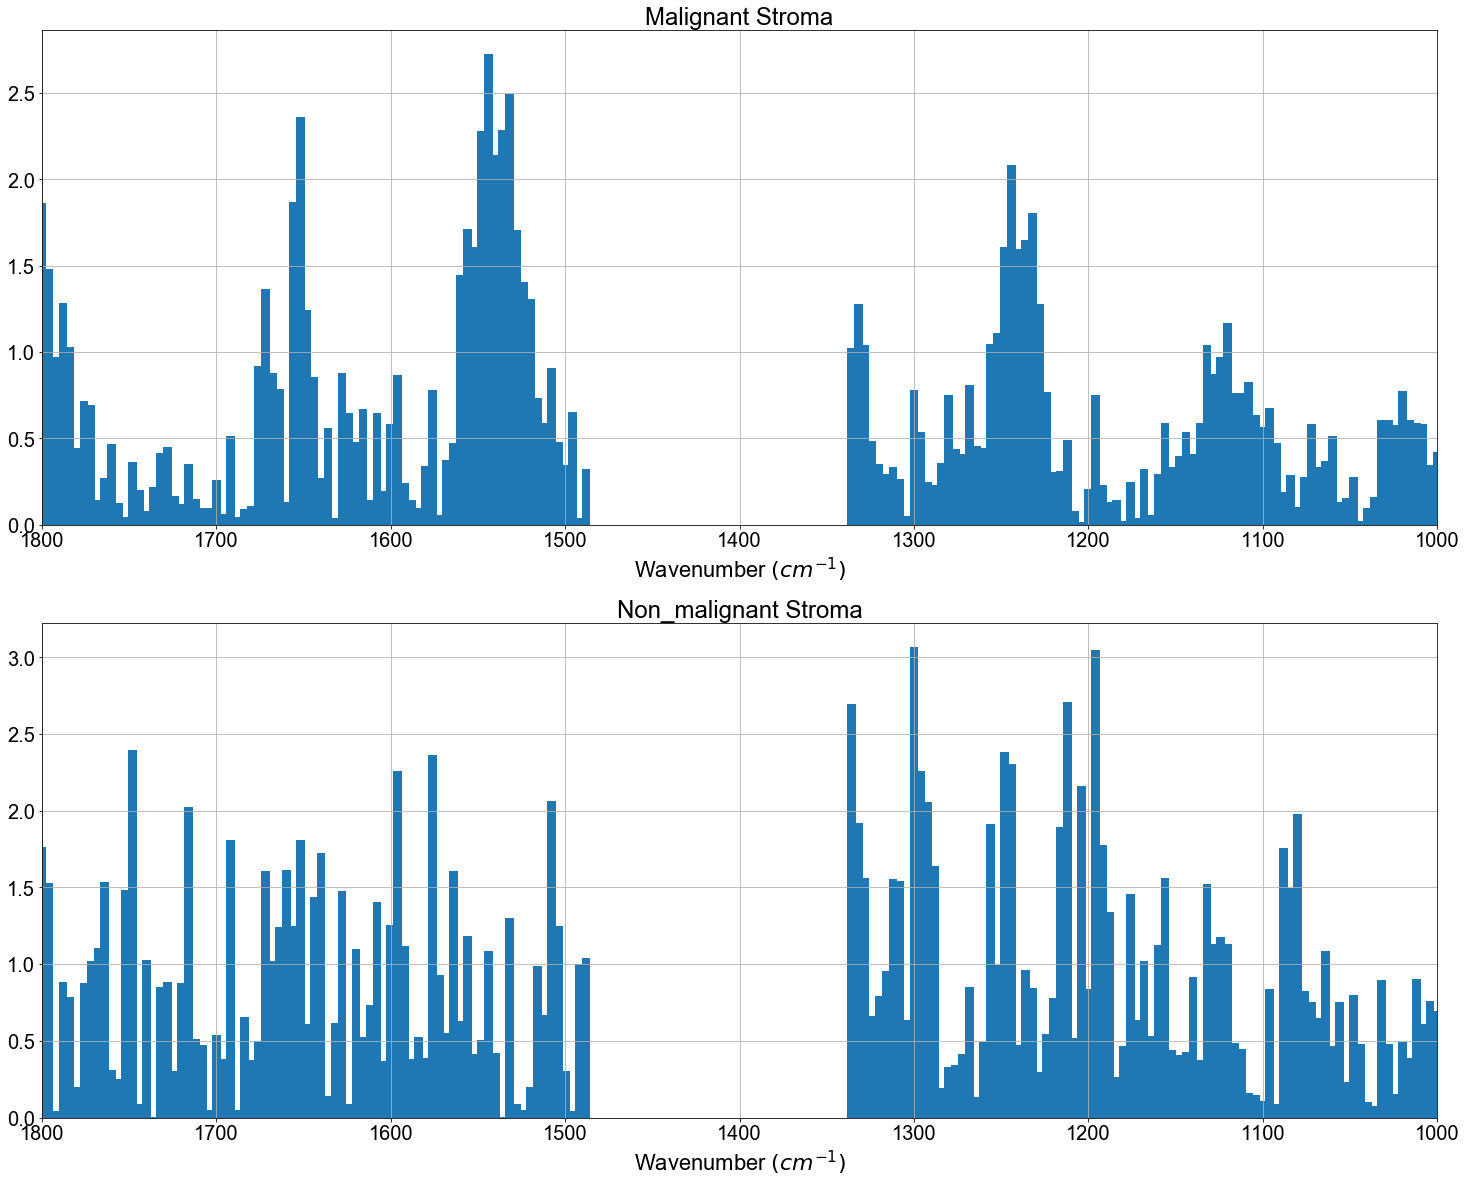

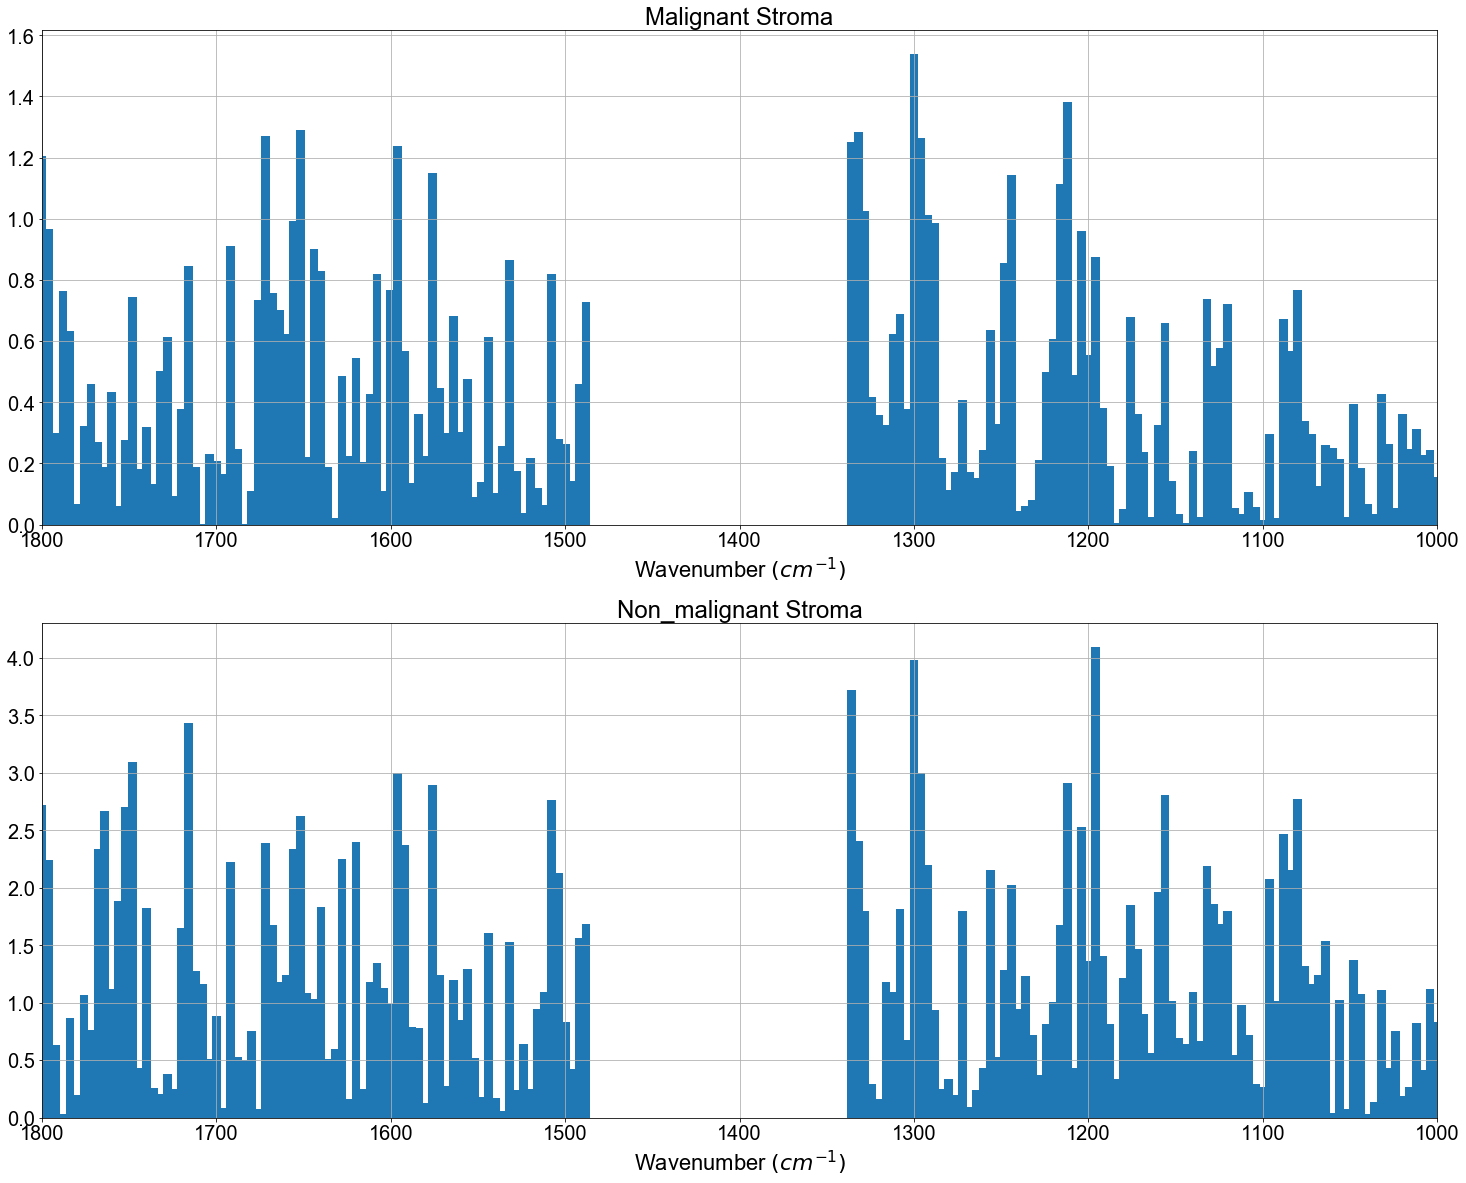

In [1063]:
for clf_name in ["LDA", "LR"]:
    
    fig = plot_importances(classifier_results[clf_name], n_best = None)

    fig.savefig(r"C:\Users\Conor\Google Drive\PhD\Breast_Cancer_Analysis_April\Feature_Importances_{}.svg".format(clf_name)
               ,format = "svg"
               ,bbox_inches = "tight")

This function is used to optimise the hyperparameters of XGboost

# Importing Breast Cancer data

In [63]:
from sklearn.preprocessing import normalize

def import_image(original):
    
    image = original.reshape(original.shape[-1], -1)

    return normalize(image, axis = 0, norm = "l1").reshape(original.shape)

In [64]:
import os
from scipy.io import loadmat

file_place = r"B:\Breast Cancer Data\br20832_cores\br20832_cores"
file_list = os.listdir(file_place)

image_list_directory = r"B:\Breast Cancer Data\overlay\overlay"
image_list = os.listdir(image_list_directory)

images = {file_name[:-4] : import_image(loadmat(os.path.join(file_place, file_name))["image"]) for file_name in file_list[:3]}

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'B:\\Breast Cancer Data\\br20832_cores\\br20832_cores'

In [ ]:
import os
from scipy.io import loadmat

file_place = "/mnt/hgfs/E/Breast Cancer Data/br20832_cores/br20832_cores"
file_list = os.listdir(file_place)

image_list_directory = "/mnt/hgfs/E/Breast Cancer Data/overlay/overlay"
image_list = os.listdir(image_list_directory)

images = {file_name[:-4] : import_image(loadmat(os.path.join(file_place, file_name))["image"]) for file_name in file_list[:3]}

In [66]:
import os
from scipy.io import loadmat
import imageio

file_place = r"E:\Breast Cancer Data\br20832_cores\br20832_cores"
file_list = os.listdir(file_place)

image_list_directory = r"E:\Breast Cancer Data\overlay\overlay"
image_list = os.listdir(image_list_directory)

#overlays = {image_list[:-4] : imageio.imread(os.path.join(image_list_directory, image_name)) for image_name in image_list}

images = {file_name[:-4] : loadmat(os.path.join(file_place, file_name))["image"] for file_name in file_list[-20:-10]}

In [132]:
images.keys()

dict_keys(['L5', 'L6', 'L7', 'L8', 'L9', 'M1', 'M10', 'M11', 'M12', 'M13'])

# Preprocess image

In [905]:
image_ref = "L5"

image = images[image_ref]
#overlay = 

PCA_NR_Components = 5

image_dataframe = pd.DataFrame(image.reshape(-1, image.shape[-1]), columns = Breast_DF_Mie.columns)

dataframe = TAT.process_data(image_dataframe, paraffin = (1340,1490))

PCA_reduced = TAT.PCA_denoise(dataframe, PCA_NR_Components)

values = pipe.fit_transform(PCA_reduced.T).T

image_P_list = pd.DataFrame(values, index = dataframe.index, columns = dataframe.columns)

image_P = image_P_list.values.reshape(image.shape[0], image.shape[1], -1)

Processing


C:\Users\Conor\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Plotting predictions for image

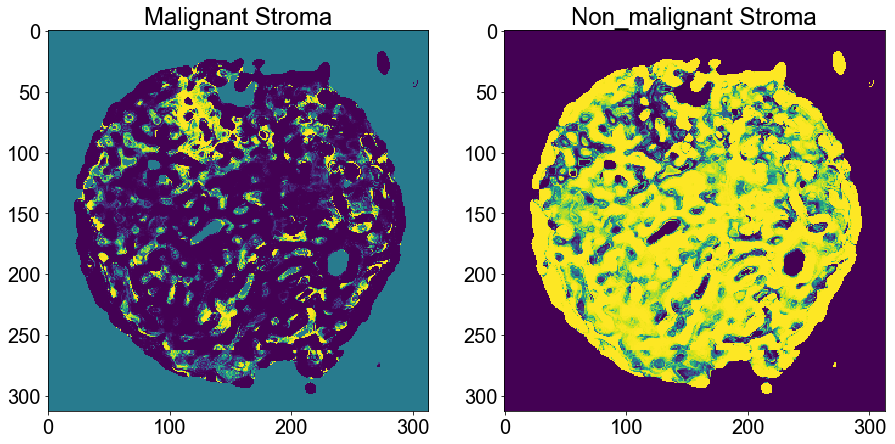

In [792]:
fig, axes = plt.subplots(ncols = len(binary_classifiers), nrows = 1, figsize = (15,10))

pred_cube = individual_predictions(image_P, binary_classifiers)

for ax, name, image in zip(axes.flat, pred_cube.keys(), pred_cube.values()):
    
    ax.set_title(name)
    ax.imshow(image)
    
plt.show()

In [75]:
import matplotlib as mpl

def individual_predictions(image, classifiers):
    
    Pred_cube = {name: classifier.predict_proba(image.reshape(-1, image.shape[-1]))[:,1].reshape(image.shape[0], image.shape[1]) for name, classifier in classifiers.items()}
    
    return Pred_cube

def prediction_plot(image, classifiers, **kwargs):
    
    # Get colours from tab10 colour list
    colours = dict(zip(classifiers.keys(), plt.get_cmap("tab10").colors))
    
    # Prediction values for each 
    Pred_DF = pd.DataFrame({name: classifier.predict_proba(image.reshape(-1, image.shape[-1]))[:,1] for name, classifier in classifiers.items()})

    Pred_DF["Winner_ID"] = Pred_DF.idxmax(axis = 1)
    Pred_DF["Winner_conf"] = Pred_DF.max(axis = 1)

    # RGB image
    RGB = np.array([colours[ID] for ID in Pred_DF["Winner_ID"]]).reshape(image.shape[0], image.shape[1], 3)
    
    # Confidence plot
    conf = Pred_DF["Winner_conf"].values.reshape(image.shape[0], image.shape[1], 1)
    
    # RGBA plot
    rgba = np.concatenate([RGB,conf], axis = 2)
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', list(colours.values()), N = len(colours))
    
    # If a threshold is supplied, use it
    if "thresh" in kwargs.keys():
        rgba[np.abs(image_P.mean(axis = 2)) < kwargs.get("thresh")] = [0,0,0,0]
        
    fig, ax = plt.subplots()
    cax = ax.imshow(rgba, cmap = cmap)
    cbar = fig.colorbar(cax, ticks = np.linspace(0, 1, len(classifiers)))
    cbar.ax.set_yticklabels(classifiers.keys())  # horizontal colorbar
    
    return rgba, conf.reshape(conf.shape[0],conf.shape[1])

In [77]:
from skimage.filters import threshold_otsu

C:\Users\Conor\Anaconda3\lib\site-packages\skimage\__init__.py:80: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\Conor\\Anaconda3\\lib\\site-packages\\pytest.py' mode='r' encoding='utf-8'>
  imp.find_module('pytest')
C:\Users\Conor\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


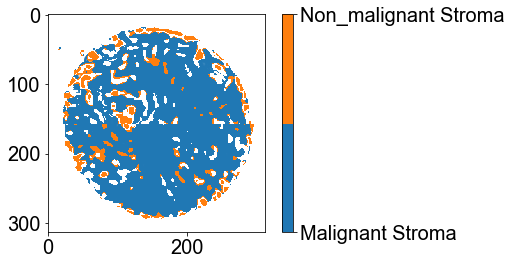

In [1070]:
rgba, conf = prediction_plot(image_P, classifier_results["LDA"], thresh = threshold_otsu(image_P.mean(axis = 2)))

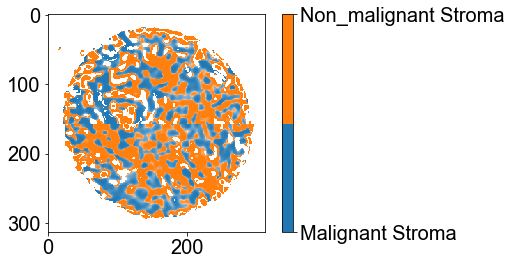

In [1071]:
rgba, conf = prediction_plot(image_P, classifier_results["LR"], thresh = threshold_otsu(image_P.mean(axis = 2)))

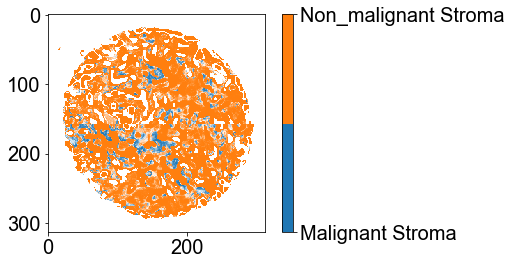

In [1072]:
rgba, conf = prediction_plot(image_P, xgbinary_classifiers, thresh = threshold_otsu(image_P.mean(axis = 2)))